In [21]:
import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from os.path import *
import pandas as pd
import shutil
import re
import random
import seg_methods as sm
import time
import voi_methods as vm
import operator
%matplotlib inline
import scipy.stats
import math
import scipy.misc

import manifold as mani
import keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from skimage.morphology import ball
import seaborn as sns
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config
sns.set(style="ticks")
%matplotlib inline

In [15]:
importlib.reload(config)
importlib.reload(vm)
C = config.Config()

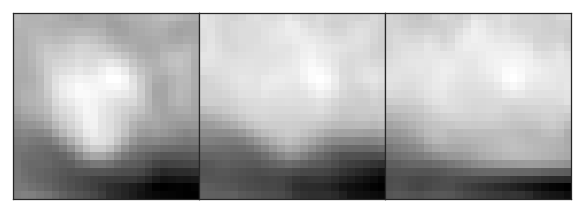

In [21]:
vm.plot_check(2,'E105066561_0', None);

In [35]:
img_fns = [fn for fn in glob.glob(join(C.unaug_dir, "*.npy"))]

In [ ]:
%matplotlib qt
importlib.reload(vm)
vm.semiauto_label_lesions()

In [14]:
importlib.reload(mani)
dm = mani.DiseaseManifold()

In [ ]:
dm.mr_gan.generator.summary()

In [16]:
gen = dm._train_gen_encoder(inputs=['z'], outputs=['mr'])

In [17]:
def metagen(gen):
    while True:
        latent_vec, real_img = next(gen)
        batch_size = latent_vec.shape[0]
        yield latent_vec, np.ones((batch_size, 1))
mg = metagen(gen)

In [ ]:
dm.mr_gan.train(epochs=100, gen=gen)

In [ ]:
dm.mr_gan.g_train(epochs=1000, gen=gen)

In [ ]:
dm.mr_gan.generator.fit_generator(gen, 50, epochs=30);

In [ ]:
dm.mr_gan.combined.fit_generator(mg, 100, epochs=50);

### Patches for Lesion detector

In [27]:
I = np.load(join(C.full_img_dir, "4262153.npy"))

In [37]:
accnum = "4262153"
load_dir = join(C.dcm_dirs[0], accnum)
art,D = hf.load_img(join(load_dir, "nii_dir", "20s.nii.gz"))
ven,_ = hf.load_img(join(load_dir, "nii_dir", "70s.nii.gz"))
eq,_ = hf.load_img(join(load_dir, "nii_dir", "3min.nii.gz"))
I = np.stack((art, ven, eq), -1)

In [55]:
tr.rescale_img(I, [1,1,1], D).shape

(380, 380, 240, 3)

In [97]:
importlib.reload(tr)
cropIs = tr.split_img(I, D, L=100)#, target_dims=[24,24,24])

In [89]:
cropIs[-3].max()

5.942105263157892

(18, 100, 100, 100, 3)


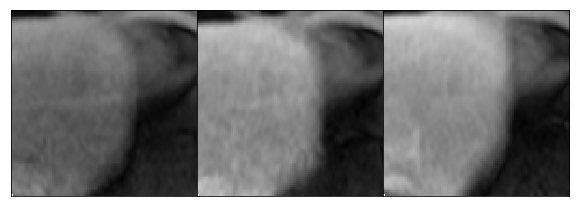

In [102]:
print(cropIs.shape)
vis.draw_slices(cropIs[15], normalize=[0,200])

### Paula

In [57]:
importlib.reload(drm)
drm.load_clinical_vars()

### Etiology

In [3]:
xls_path = r"Z:\Sophie\Ethiologyproject\HCC Etiology Project Master Spreadsheet.xlsx"

In [114]:
df = pd.read_excel(xls_path)
df = df[df["Include"]==1]

In [115]:
df.loc[df["HepC_ViralLoad"] == '299.000 (3/28/2014) ', "HepC_ViralLoad"] = 299

df.loc[df["HepB_ViralLoad"] == '<5', "HepB_ViralLoad"] = 2.5
df.loc[df["HepB_ViralLoad"] == '<20', "HepB_ViralLoad"] = 10

df.loc[df["Tumor_Dx_MRI_Accession"]=="E100209927", "Alcohol"] = -1

In [ ]:
df = df.fillna(0)

In [ ]:
coords_df = pd.read_excel(xls_path, sheetname=1)

In [116]:
categories = ["HBV", "HCV", "EtOH", "NASH"]

In [117]:
DF = {category: df[df["Etiology"] == category] for category in categories}

In [118]:
#DF["NASH"] = df[(df["HepC"] < 1) & (df["HepB"] < 1) & (df["Alcohol"] < 1)]
#DF["Nonviral"] = df[(df["HepC"] < 1) & (df["HepB"] < 1)]

In [ ]:
for cls in C.cls_names:
    df = pd.read_excel(C.coord_xls_path, sheet_name=C.sheetname)
    df = df[df["cls"] == cls]
    print(cls, len(df))

In [ ]:
[print(d,len(DF[d])) for d in DF];

#### P-values

In [103]:
cats = list(zip(["HBV"]*3+["HCV"]*2+["EtOH"],["HCV","EtOH","NASH","EtOH","NASH","NASH"]))

In [ ]:
col = "TumorSize"#"Age at Diagnosis"
for cat1, cat2 in cats:
    print(cat1, cat2, "%.3f" % \
          scipy.stats.mannwhitneyu(DF[cat1][col], DF[cat2][col]).pvalue)

print("%.4f" % scipy.stats.kruskal(*[DF[cat][col].dropna() for cat in categories])[1])

In [ ]:
for cat1, cat2 in cats:
    cont_table = np.array([[sum(DF[cat1]["Gender"]=="M"), sum(DF[cat1]["Gender"]=="F")],
                           [sum(DF[cat2]["Gender"]=="M"), sum(DF[cat2]["Gender"]=="F")]], int)
    print(cat1, cat2, "%.3f" % \
          scipy.stats.fisher_exact(cont_table)[1])
    
print("%.3f" % scipy.stats.chi2_contingency(pd.crosstab(df["Etiology"], df["Gender"]))[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["BCLC"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    if "NASH" not in [cat1, cat2]:
        cont_table.drop(0, axis=1, inplace=True)
    print(cat1, cat2, "%.3f" % scipy.stats.chi2_contingency(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["CPS"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.chi2_contingency(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Cirrhosis"])
xtab.drop(-1, axis=1, inplace=True)
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["AFP>400"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Portal_Invasion"])
xtab = xtab[[0,1]]
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

In [234]:
df["Unifocal"] = df["NumberLesions"] == 1

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Unifocal"])
for cat1, cat2 in cats:
    cont_table = xtab.loc[[cat1,cat2]]
    print(cat1, cat2, "%.3f" % scipy.stats.fisher_exact(cont_table)[1])
print("%.3f" % scipy.stats.chi2_contingency(xtab)[1])

#### graphing

In [43]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    """topbar = plt.Rectangle((0,0),1,1,fc="#C3C3C3", edgecolor = 'none')
    midbar = plt.Rectangle((0,0),1,1,fc='#A3A3A3',  edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='#737373',  edgecolor = 'none')
    l = plt.legend([bottombar, midbar, topbar],
                   ['High Lipiodol', 'Medium Lipiodol', 'Low Lipiodol'], loc='upper left')#, ncol=2, prop={'size':16})
    l.draw_frame(False)"""
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, dpi=150, pad_inches=0, transparent=True) #, width=5
    plt.close()

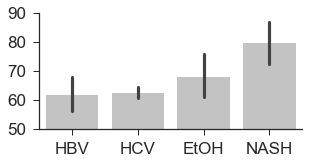

In [140]:
plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
kwargs = {"data":df, "size":3, "kind":"bar", "color":"#C3C3C3", "legend":False}
sns.set(style="ticks", font_scale=1.7)
g = sns.factorplot(x="Etiology", y="Age at Diagnosis", order=categories, aspect=1.7, **kwargs)
g.set(yticks=[50,60,70,80,90], ylim=(50,90));
for gax in g.axes[0]:
    gax.set_xlabel("")
    gax.set_ylabel("")
g.fig.savefig("D:\\Etiology\\graphs\\age.png", pad_inches=0, transparent=True) #, width=5

In [ ]:
plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
kwargs = {"data":df, "size":3, "kind":"bar", "color":"#C3C3C3", "legend":False}
sns.set(style="ticks", font_scale=1.7)
g = sns.factorplot(x="Etiology", y="TumorSize", order=categories, aspect=1.7, **kwargs)
#g.set(yticks=[50,60,70,80,90], ylim=(50,90));
for gax in g.axes[0]:
    gax.set_xlabel("")
    gax.set_ylabel("")
g.fig.savefig("D:\\Etiology\\graphs\\lesionsize.png", pad_inches=0, transparent=True) #, width=5

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Gender"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab["M"], width=.8)#, yerr=xtab["M"]
p2 = plt.bar(range(4), xtab["F"], width=.8, bottom=xtab["M"])
plt.legend((p2, p1), ('Female', 'Male'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\gender.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["BCLC"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p = [plt.bar(range(4), xtab["D"], width=.8)]
p.append(plt.bar(range(4), xtab["C"], width=.8, bottom=xtab["D"]))
p.append(plt.bar(range(4), xtab["B"], width=.8, bottom=xtab["D"]+xtab["C"]))
p.append(plt.bar(range(4), xtab["A"], width=.8, bottom=xtab["D"]+xtab["C"]+xtab["B"]))
p.append(plt.bar(range(4), xtab[0], width=.8, bottom=xtab["D"]+xtab["C"]+xtab["B"]+xtab["A"]))
plt.legend(p[::-1], ('D', 'C', 'B', 'A', '0')[::-1], bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\bclc.png", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["CPS"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p = [plt.bar(range(4), xtab["C"], width=.8)]
p.append(plt.bar(range(4), xtab["B"], width=.8, bottom=xtab["C"]))
p.append(plt.bar(range(4), xtab["A"], width=.8, bottom=xtab["C"]+xtab["B"]))
plt.legend(p[::-1], ('A', 'B', 'C'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\cps.png", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Cirrhosis"]).drop(-1,axis=1).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[0], width=.8)
p2 = plt.bar(range(4), xtab[1], width=.8, bottom=xtab[0])
plt.legend((p2, p1), ('Cirrhosis', 'No Cirrhosis'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\cirrhosis.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
df["AFP>400"] = df["AFP"]>400
xtab = pd.crosstab(df["Etiology"], df["AFP>400"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[0], width=.8)
p2 = plt.bar(range(4), xtab[1], width=.8, bottom=xtab[0])
plt.legend((p2, p1), ('>400ng/mL', '<400ng/mL'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\afp.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
xtab = pd.crosstab(df["Etiology"], df["Portal_Invasion"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[0], width=.8)
p2 = plt.bar(range(4), xtab[1], width=.8, bottom=xtab[0])
plt.legend((p2, p1), ('Invasion', 'No Invasion'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\invasion.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
df["Multifocal"] = df["NumberLesions"]!=1
xtab = pd.crosstab(df["Etiology"], df["Multifocal"]).apply(lambda r: r/r.sum(), axis=1)
xtab = xtab.loc[categories]

plt.figure(num=None, figsize=(3,1.5), dpi=100, facecolor='w', edgecolor='k')
p1 = plt.bar(range(4), xtab[False], width=.8)
p2 = plt.bar(range(4), xtab[True], width=.8, bottom=xtab[False])
plt.legend((p2, p1), ('Multifocal', 'Unifocal'), bbox_to_anchor=(1,1), borderaxespad=0., fontsize=12)
plt.axes().set_yticklabels(["0%", "50%", "100%"]);
plt.xticks(range(4), xtab.index)
plt.axes().set_yticks([0,.5,1], minor=False)
sns.despine(top=True, right=True)
ax = plt.axes()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig("D:\\Etiology\\graphs\\multifocal.png", dpi=150, bbox_inches='tight', pad_inches=0, transparent=True)

#### etc

In [66]:
coords_df = pd.read_excel(xls_path, sheetname=1)

In [46]:
importlib.reload(vm)
vm.save_segs_as_imgs()

In [57]:
importlib.reload(vm)
vm.remove_lesion_id("5276207")

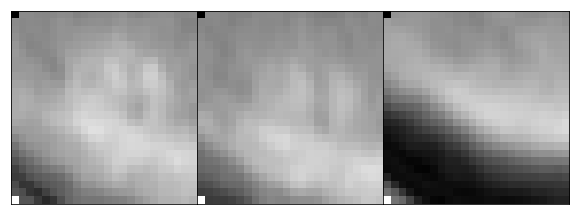

In [23]:
importlib.reload(vm)
vm.plot_check(1,"4262153_1");

In [62]:
importlib.reload(vm)
vm.save_seg_set(unaug=False, num_cores=2, overwrite=False)

### Semiauto rename

In [ ]:
importlib.reload(hf)
hf.semiauto_rename_phases(C.dcm_dir, C.phase_dirs)